# Set Up

In [2]:
# Basic imports
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Financial imports
import yfinance as yf
import pandas_datareader as pdr

# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Data Loading

In [ ]:
def load_data():
    """
    Load gold futures data from a CSV file.
    
    Parameters:
        file_path (str): Path to the CSV file containing gold futures data
        
    Returns:
        DataFrame: Pandas DataFrame with loaded data
    """
    
    data = pd.read_csv('./data/gold_futures.csv',index_col = 0, parse_dates=True)
    # Convert 'Price' to numeric
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data.sort_index(inplace=True)

    dxy = pd.read_csv('./data/dxy.csv',index_col = 0, parse_dates=True)
    real_yields = pd.read_csv('./data/real_yields.csv',index_col = 0, parse_dates=True)
    vix = pd.read_csv('./data/vix.csv',index_col = 0, parse_dates=True)

    merged_data = data.join([dxy, real_yields, vix], how='left').ffill()

    return merged_data

# Training & Test Split

In [4]:
def prepare_training_data(data, train_ratio=0.95, features = ["Price"]):
    """
    Extract feature columns and split data into training and testing sets.
    
    Parameters:
        data (DataFrame): Preprocessed data
        train_ratio (float): Ratio of data to use for training (default: 0.95)
        
    Returns:
        tuple: (training data, test data, scaler)
    """
    data = data[features].copy()
    dataset = data.values
    
    # Determine train/test split point
    training_size = int(np.ceil(len(dataset) * train_ratio))
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    # Split into train and test sets
    train_data = scaled_data[:training_size]
    test_data = scaled_data[training_size:]
    
    return train_data, test_data, scaler

In [5]:
def create_sequences(data, seq_length, target_col=0):
    """
    Create sequences for LSTM model input with multiple features.
    
    Parameters:
        data (ndarray): Input data array where columns are features
        seq_length (int): Length of sequence for LSTM input
        target_col (int): Index of the target column to predict
        
    Returns:
        tuple: (X sequences, y targets)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_col].reshape(1))
    
    return np.array(X), np.array(y)

# Model

In [6]:
def build_model(input_shape):
    """
    Build and compile LSTM model.
    
    Parameters:
        input_shape (tuple): Shape of input data
        
    Returns:
        Model: Compiled LSTM model
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128, kernel_regularizer=regularizers.L2(0.002)))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    learning_rate = 0.0008
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    
    return model

In [7]:
def train_model(model, X_train, y_train, epochs=40):
    """
    Train the LSTM model.
    
    Parameters:
        model: LSTM model to train
        X_train (ndarray): Training features
        y_train (ndarray): Training targets
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        
    Returns:
        History: Training history
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr], 
        validation_split=0.2
    )
    return history

# Evaluation

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    
    Parameters:
        y_true (array): Actual values
        y_pred (array): Predicted values
        
    Returns:
        float: MAPE value as percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [9]:
def evaluate_model(model, X_test, y_test, scaler, target_col=0):
    """
    Evaluate model performance on test data with multiple features.
    
    Parameters:
        model: Trained model
        X_test (ndarray): Test features
        y_test (ndarray): Test targets (single column)
        scaler: Fitted scaler for inverse transformation
        target_col (int): Index of the target column
        
    Returns:
        tuple: (predictions DataFrame, MAPE score)
    """
    # Make predictions
    pred = model.predict(X_test)
    
    # Create templates for inverse transformation
    y_test_template = np.zeros((len(y_test), scaler.n_features_in_))
    pred_template = np.zeros((len(pred), scaler.n_features_in_))
    
    # Place the predictions and actual values in the right column
    y_test_template[:, target_col] = y_test.flatten()
    pred_template[:, target_col] = pred.flatten()
    
    # Inverse transform to get actual values
    y_test_inv = scaler.inverse_transform(y_test_template)[:, target_col]
    pred_inv = scaler.inverse_transform(pred_template)[:, target_col]
    
    # Create results DataFrame
    test = pd.DataFrame({
        'actual': y_test_inv,
        'pred': pred_inv
    })
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test['actual'], test['pred'])
    
    return test, mape

In [10]:
def plot_results(actual, predicted, title="Gold Futures Price Prediction"):
    """
    Plot actual vs predicted values.
    
    Parameters:
        actual (array): Actual price values
        predicted (array): Predicted price values
        title (str): Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Probability Distribution

In [35]:
# 1. MODEL DEFINITION
def build_quantile_model(input_shape, quantiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    """
    Build LSTM model that predicts multiple quantiles.
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128, kernel_regularizer=regularizers.L2(0.002)))
    model.add(Dropout(0.5))
    model.add(Dense(units=len(quantiles)))  # One output per quantile
    
    def quantile_loss(quantile, y_true, y_pred):
        """Quantile loss function for a specific quantile"""
        error = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * error, (quantile - 1) * error))
    
    # Custom loss that combines all quantile losses
    def combined_quantile_loss(y_true, y_pred):
        y_true = tf.expand_dims(y_true, axis=-1)  # Reshape for broadcasting
        loss = 0
        for i, q in enumerate(quantiles):
            loss += quantile_loss(q, y_true, tf.expand_dims(y_pred[:, i], axis=-1))
        return loss
    
    model.compile(
        optimizer=Adam(learning_rate=0.0008), 
        loss=combined_quantile_loss
    )
    
    return model, quantiles

# 2. DATA PREPARATION
def prepare_quantile_data(data, train_ratio=0.95, features=["Price", "DXY", "VIX"], seq_length=14):
    """
    Prepare data for quantile regression model.
    """
    # Get training data
    train_data, test_data, scaler = prepare_training_data(data, train_ratio, features)
    
    # Create sequences
    target_col = 0  # Assuming Price is the target column
    X_train, y_train_raw = create_sequences(train_data, seq_length, target_col)
    X_test, y_test_raw = create_sequences(test_data, seq_length, target_col)
    
    # Reshape y values for quantile model
    y_train = y_train_raw.flatten()
    y_test = y_test_raw.flatten()
    
    return X_train, y_train, X_test, y_test, scaler, target_col

# 3. TRAINING FUNCTION
def train_quantile_model(model, X_train, y_train, epochs=40):
    """
    Train the quantile regression model.
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr], 
        validation_split=0.2
    )
    
    return history

# 4. EVALUATION AND VISUALIZATION
def evaluate_quantile_model(model, X_test, y_test, scaler, quantiles, target_col=0):
    """
    Evaluate quantile model and calculate appropriate metrics.
    """
    # Get predictions for all quantiles
    quantile_preds = model.predict(X_test)
    
    # Create arrays for inverse scaling
    y_test_template = np.zeros((len(y_test), scaler.n_features_in_))
    y_test_template[:, target_col] = y_test
    y_test_inv = scaler.inverse_transform(y_test_template)[:, target_col]
    
    # Initialize array to store unscaled predictions
    quantile_preds_inv = np.zeros((len(quantile_preds), len(quantiles)))
    
    # Inverse transform each quantile prediction
    for i in range(len(quantiles)):
        pred_template = np.zeros((len(quantile_preds), scaler.n_features_in_))
        pred_template[:, target_col] = quantile_preds[:, i]
        quantile_preds_inv[:, i] = scaler.inverse_transform(pred_template)[:, target_col]
    
    # Calculate quantile score (pinball loss)
    quantile_scores = []
    for i, q in enumerate(quantiles):
        errors = y_test_inv - quantile_preds_inv[:, i]
        pinball_loss = np.mean(np.maximum(q * errors, (q - 1) * errors))
        quantile_scores.append(pinball_loss)
    
    # Check if predictions are correctly ordered (quantile 0.9 > 0.5 > 0.1)
    monotonicity_violations = 0
    for i in range(len(quantile_preds_inv)):
        for j in range(len(quantiles)-1):
            if quantile_preds_inv[i, j] > quantile_preds_inv[i, j+1]:
                monotonicity_violations += 1
    
    return {
        'y_test': y_test_inv,
        'quantile_preds': quantile_preds_inv,
        'quantile_scores': quantile_scores,
        'monotonicity_violations': monotonicity_violations
    }

def plot_quantile_predictions(results, quantiles, num_days=30):
    """
    Plot the predicted quantiles against actual values.
    """
    # Get most recent predictions for visualization
    plot_idx = slice(-num_days, None)
    
    plt.figure(figsize=(14, 8))
    
    # Plot the actual values
    plt.plot(results['y_test'][plot_idx], 'ko-', label='Actual Price', linewidth=2)
    
    # Plot the median prediction
    median_idx = quantiles.index(0.5) if 0.5 in quantiles else len(quantiles) // 2
    plt.plot(results['quantile_preds'][plot_idx, median_idx], 'r-', 
             label=f'Median Prediction (q={quantiles[median_idx]})', linewidth=2)
    
    # Plot the quantile ranges
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(quantiles)))
    for i in range(len(quantiles)-1):
        # Skip if quantiles are not in pairs
        if i % 2 == 0 and i+1 < len(quantiles):
            # Fill between symmetric quantiles
            lower_q = min(quantiles[i], quantiles[i+1])
            upper_q = max(quantiles[i], quantiles[i+1])
            plt.fill_between(
                range(len(results['y_test'][plot_idx])),
                results['quantile_preds'][plot_idx, i],
                results['quantile_preds'][plot_idx, i+1],
                color=colors[i], alpha=0.3,
                label=f'Range {lower_q}-{upper_q}'
            )
    
    plt.title('Gold Price Forecasts with Prediction Intervals', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Gold Price', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(results, quantiles, day_index=-1):
    """
    Plot the predicted distribution for a specific day.
    """
    plt.figure(figsize=(12, 6))
    
    # Extract predictions for the specified day
    day_preds = results['quantile_preds'][day_index]
    actual = results['y_test'][day_index]
    
    # Plot quantile points
    plt.plot(quantiles, day_preds, 'bo-', linewidth=2, markersize=8)
    
    # Highlight the actual value
    plt.axhline(y=actual, color='r', linestyle='--', label=f'Actual: {actual:.2f}')
    
    # Formatting
    plt.title(f'Gold Price Distribution Forecast', fontsize=16)
    plt.xlabel('Quantile', fontsize=14)
    plt.ylabel('Gold Price', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add annotations for key quantiles
    for i, q in enumerate(quantiles):
        plt.annotate(
            f'{day_preds[i]:.2f}', 
            (quantiles[i], day_preds[i]),
            textcoords="offset points",
            xytext=(0,10), 
            ha='center'
        )
    
    plt.tight_layout()
    plt.show()

# 5. MAIN EXECUTION FUNCTION
def run_quantile_prediction(data, features=["Price", "DXY", "VIX"], seq_length=14, 
                           quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
    """
    Complete pipeline to train and evaluate quantile model.
    """
    # Prepare data
    X_train, y_train, X_test, y_test, scaler, target_col = prepare_quantile_data(
        data, features=features, seq_length=seq_length
    )
    
    # Build model
    model, quantiles = build_quantile_model(
        input_shape=(X_train.shape[1], X_train.shape[2]), 
        quantiles=quantiles
    )
    
    # Train model
    history = train_quantile_model(model, X_train, y_train)
    
    # Evaluate model
    results = evaluate_quantile_model(model, X_test, y_test, scaler, quantiles, target_col)
    
    # Print metrics
    print("Quantile Model Evaluation:")
    print(f"Monotonicity violations: {results['monotonicity_violations']}")
    print("Quantile scores:")
    for i, q in enumerate(quantiles):
        print(f"  Quantile {q}: {results['quantile_scores'][i]:.4f}")
    
    # Visualize results
    plot_quantile_predictions(results, quantiles, num_days=236)
    plot_prediction_distribution(results, quantiles)
    
    return model, results, history


Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.3642 - val_loss: 0.3525 - learning_rate: 8.0000e-04
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4780 - val_loss: 0.2987 - learning_rate: 8.0000e-04
Epoch 3/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4088 - val_loss: 0.2440 - learning_rate: 8.0000e-04
Epoch 4/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3526 - val_loss: 0.2426 - learning_rate: 8.0000e-04
Epoch 5/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3175 - val_loss: 0.2828 - learning_rate: 8.0000e-04
Epoch 6/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2928 - val_loss: 0.1707 - learning_rate: 8.0000e-04
Epoch 7/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2729 - val_loss: 0.1671 - learning_rate: 8.0000e-04
Epoch 8/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2550 - val_loss: 0.1571 - learning_rate: 8.0000e-04
Epoch 9/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2384 - val_loss: 

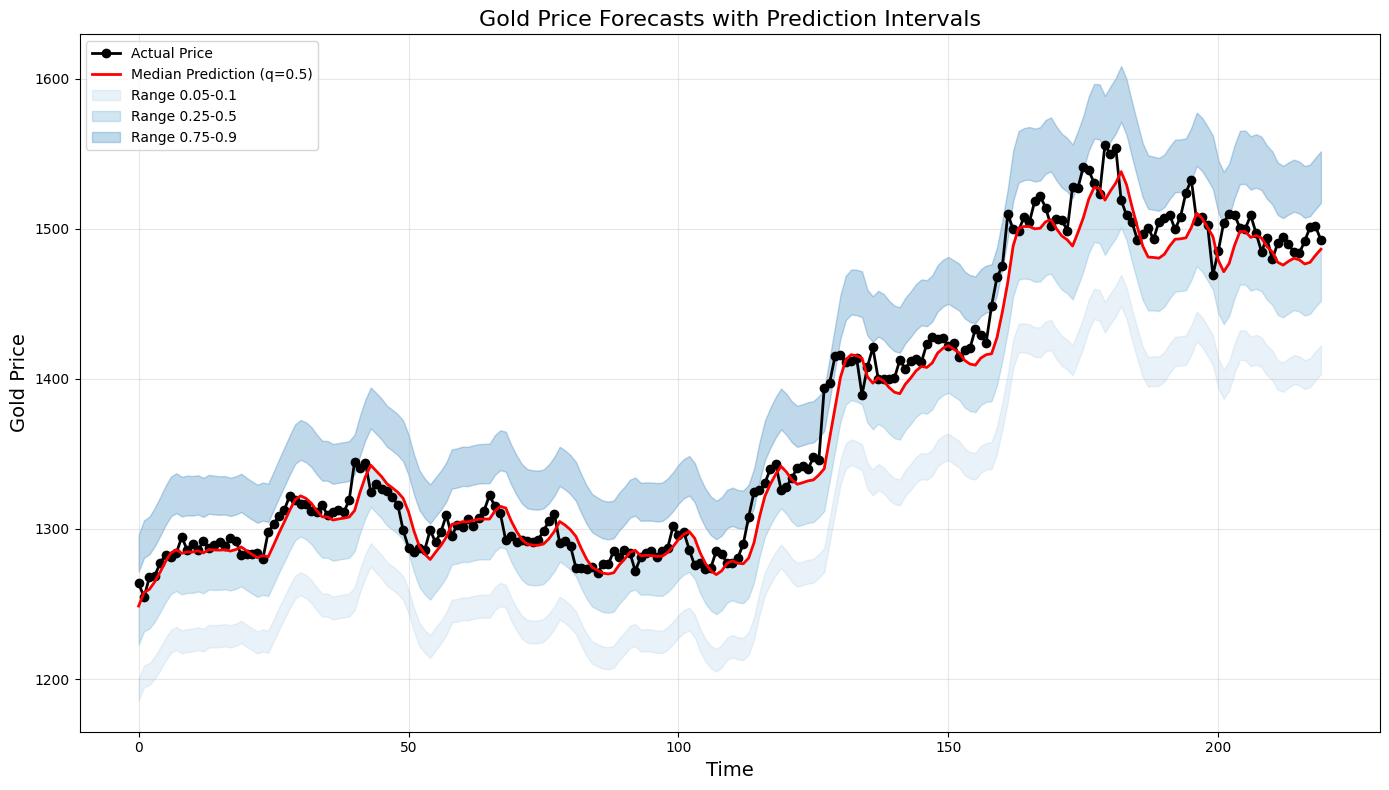

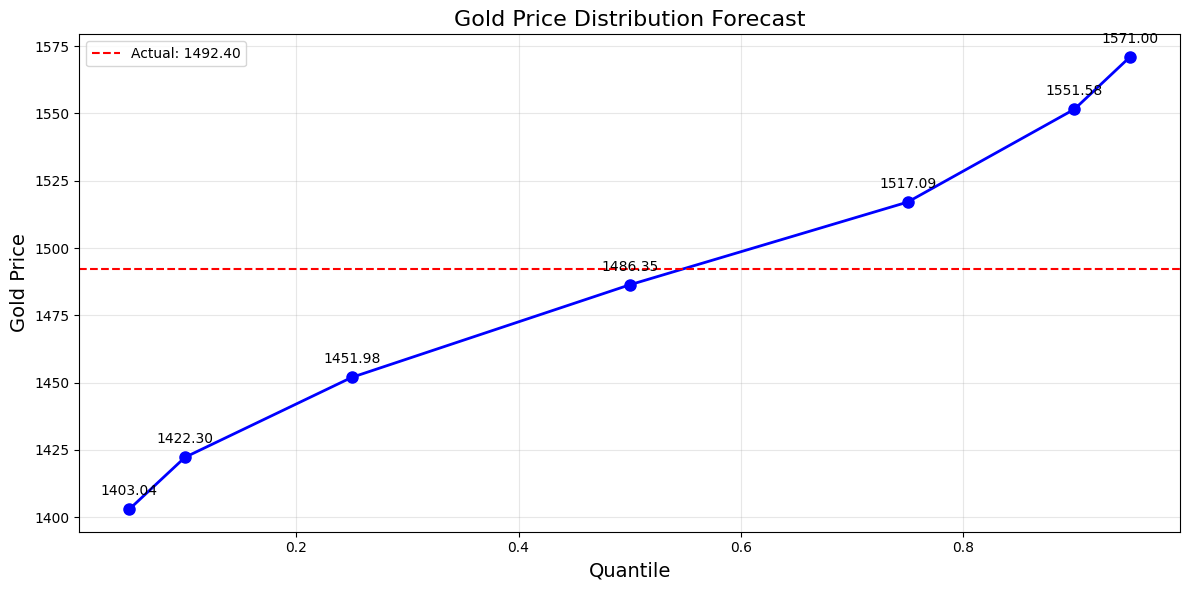

In [ ]:
# Load data with your existing function
data = load_data()
features = ["Price", "DXY", "VIX"]
quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Run the quantile prediction with custom quantiles if desired
model, results, history = run_quantile_prediction(
    data, 
    features=features,
    quantiles=quantiles,
    seq_length=30
)

# For future predictions with new data
def predict_distribution(model, new_data, scaler, quantiles, target_col=0):
    """
    Generate quantile predictions for new data.
    """
    # Assume new_data is already preprocessed, scaled and in sequence form
    quantile_preds = model.predict(new_data)
    
    # Inverse transform predictions
    quantile_preds_inv = np.zeros((len(quantile_preds), len(quantiles)))
    for i in range(len(quantiles)):
        pred_template = np.zeros((len(quantile_preds), scaler.n_features_in_))
        pred_template[:, target_col] = quantile_preds[:, i]
        quantile_preds_inv[:, i] = scaler.inverse_transform(pred_template)[:, target_col]
    
    return quantile_preds_inv

In [13]:
# # Run the quantile prediction with custom quantiles if desired
# model_price, results_price, history_price = run_quantile_prediction(
#     data, 
#     features=["Price"],
#     quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
# )

# Run

## Model 1

In [14]:
# # Load and prepare data
# data = load_data()

# # Specify which features to use
# features = ["Price", "DXY", "VIX"]  # Update with your actual column names

# # Prepare training data
# train_data, test_data, scaler = prepare_training_data(data, train_ratio=0.95, features=features)

# # Create sequences
# seq_length = 14  # Example sequence length
# target_col = 0  # Index of the target column (Price is the first column)
# X_train, y_train = create_sequences(train_data, seq_length, target_col)
# X_test, y_test = create_sequences(test_data, seq_length, target_col)

# # Build and train model
# model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
# history = train_model(model, X_train, y_train)

# # Evaluate model
# test_results, mape = evaluate_model(model, X_test, y_test, scaler, target_col)

# # Print results
# print(f"MAPE: {mape:.2f}%")

# # Plot results
# plot_results(test_results['actual'], test_results['pred'], title="Gold Futures Price Prediction")